In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('final_total_data.csv')

## TF-IDF 유사도

In [3]:
from konlpy.tag import Mecab

mecab = Mecab()

def mecab_tokenizer(text):
    return mecab.morphs(text)

In [4]:
total_sim_tf = []
tfidf_vectorizer = TfidfVectorizer(tokenizer=mecab_tokenizer)
for fir, sec in tqdm(zip(df['고객리뷰'], df['사장답글']), total=len(df)):
    try:
        sentences = (fir, sec)
        tfidf_matrix = tfidf_vectorizer.fit_transform(sentences)
        cos_similar = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
        total_sim_tf.append(cos_similar[0][0])
    except Exception as e:
        total_sim_tf.append(0)

In [5]:
df['tf-idf'] = total_sim_tf

<AxesSubplot:xlabel='tf-idf', ylabel='Count'>

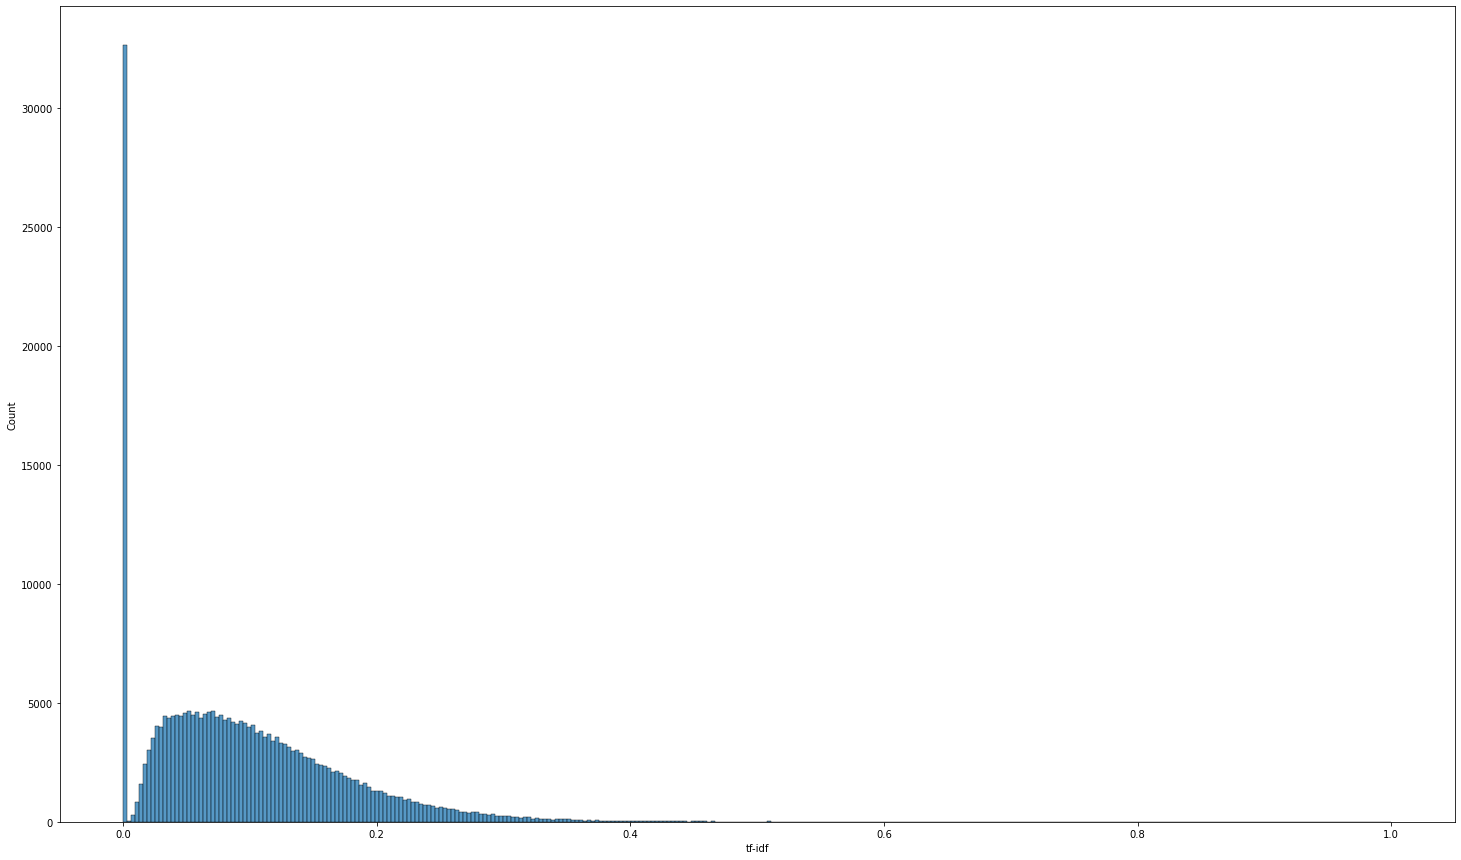

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
sns.histplot(x='tf-idf', data=df, ax=ax)

In [7]:
df['tf-idf'].describe()

count    256030.000000
mean          0.097087
std           0.076655
min           0.000000
25%           0.039874
50%           0.084836
75%           0.140216
max           1.000000
Name: tf-idf, dtype: float64

## Glove 유사도

In [8]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from konlpy.tag import Okt

okt=Okt()
glove_input_file = 'glove.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
filename = 'glove.6B.100d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)

/tmp/ipykernel_653/3172376282.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [9]:
total_sim_glove = []
for fir, sec in tqdm(zip(df['고객리뷰'], df['사장답글']), total=len(df)):
    try:
        f_n = okt.nouns(fir)
        s_n = okt.nouns(sec)
        f_total = []
        for f_w in f_n:
            try:
                f_total.append(model[f_w])
            except Exception as e:
                continue
        f_emb = sum(f_total)/len(f_total)
        
        s_total = []
        for s_w in s_n:
            try:
                s_total.append(model[s_w])
            except Exception as e:
                continue
        s_emb = sum(s_total)/len(s_total)
        res = cosine_similarity(f_emb.reshape(1,-1), s_emb.reshape(1,-1))
        total_sim_glove.append(res[0][0])
    except Exception as e:
        total_sim_glove.append(0)

In [10]:
df['glove'] = total_sim_glove

<AxesSubplot:xlabel='glove', ylabel='Count'>

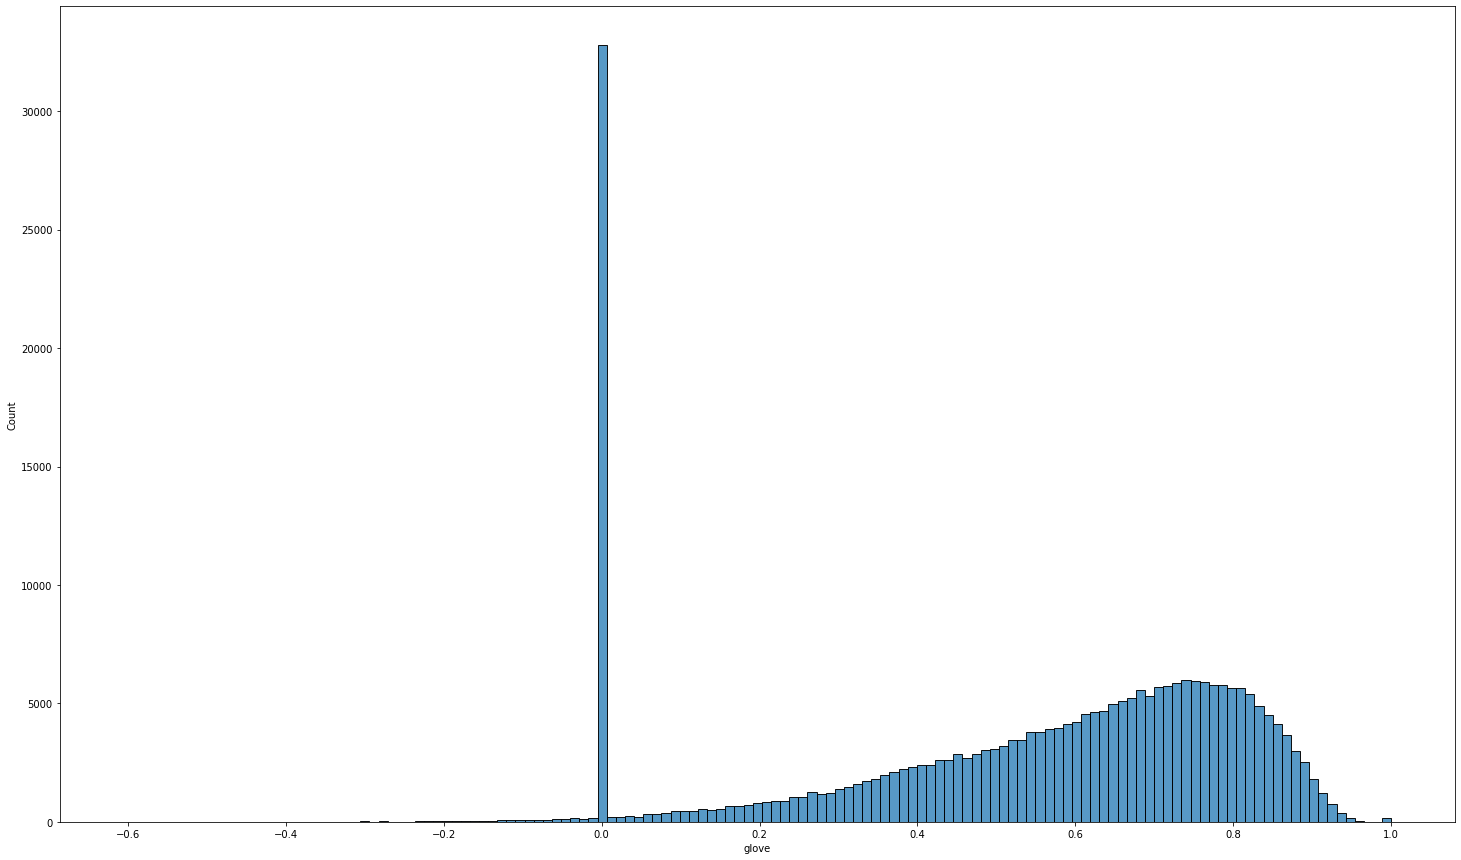

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
sns.histplot(x='glove', data=df, ax=ax)

In [12]:
df['glove'].describe()

count    256030.000000
mean          0.535048
std           0.278191
min          -0.605853
25%           0.384325
50%           0.613968
75%           0.752278
max           1.000000
Name: glove, dtype: float64

## Sentence-BERT 유사도

In [13]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [14]:
total_sim_SBERT = []
for fir, sec in tqdm(zip(df['고객리뷰'], df['사장답글']), total=len(df)):
    try:
        emb1 = model.encode(fir, convert_to_tensor=True)
        emb2 = model.encode(sec, convert_to_tensor=True)
        cosine_scores = util.pytorch_cos_sim(emb1, emb2)
        total_sim_SBERT.append(float(cosine_scores[0][0]))
    except Exception as e:
        total_sim_SBERT.append(0)

In [15]:
df['SBERT'] = total_sim_SBERT

<AxesSubplot:xlabel='SBERT', ylabel='Count'>

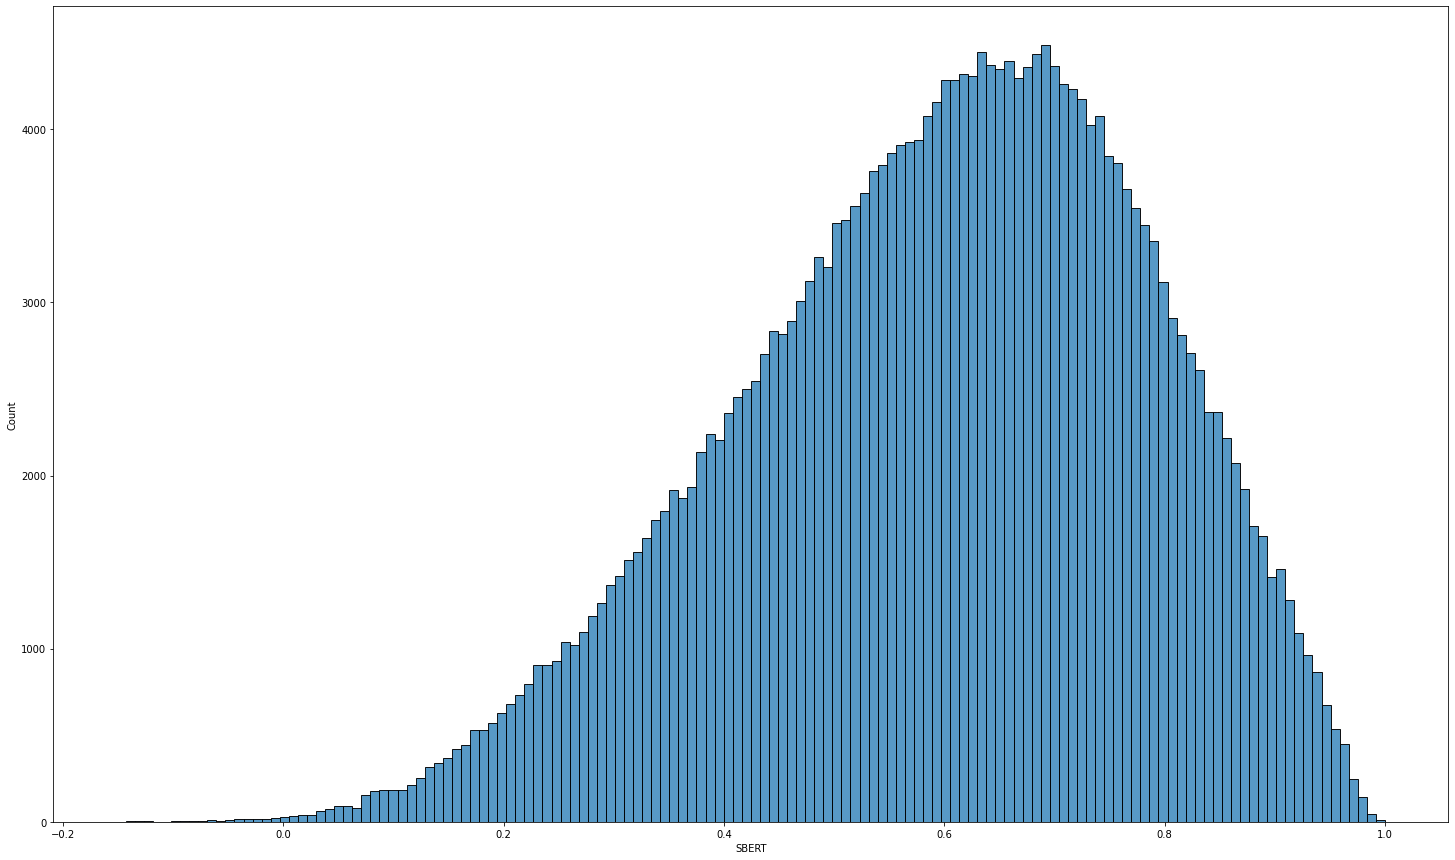

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 15))
sns.histplot(x='SBERT', data=df, ax=ax)

In [17]:
df['SBERT'].describe()

count    256030.000000
mean          0.597156
std           0.184920
min          -0.151229
25%           0.473344
50%           0.613835
75%           0.735417
max           1.000000
Name: SBERT, dtype: float64